In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# confirm Keras sees the GPU
from keras import backend as K
assert len(K.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.95)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import datetime
#Uncomment to run on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
t = str(datetime.datetime.now())
t=t.replace(' ','-')
t=t.replace(':','-')
NAME = "Galaxy-zoo-"+t
print(NAME)
tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
DIR = "E:/Projects/Neural Net/Galaxy Zoo/Data/images_training_rev1"

train_path = DIR + "/train_reduced"
validate_path = DIR + "/ValidationFolder"

Galaxy-zoo-2020-05-20-18-49-49.378760


In [33]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]


def append_ext(fn):
    return fn + ".jpg"


traindf = pd.read_csv("E:/Projects/Neural Net/Galaxy Zoo/Data/training_solutions_rev1/training_solutions_rev1.csv")
traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext)

def random_input(img):
    shape = img.shape
    size = tf.convert_to_tensor(shape[:2])
    image = tf.convert_to_tensor(img)
    image = tf.image.central_crop(image, 0.6)
    image = tf.image.resize(image, size, method='nearest')
    image = K.eval(image)
    return image

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.10,
    #preprocessing_function = random_input,
)

valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.85)

In [34]:
train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224,224))


STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=64,
    seed=123,
    shuffle=False,
    class_mode="raw",
    target_size=(224, 224))

STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 562 validated image filenames.
Found 62 validated image filenames.


In [ ]:
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_generator.mean=train_generator
valid_generator.mean=valid_generator

In [35]:
from keras.models import Sequential, Model,load_model
from keras.applications.resnet import ResNet152, ResNet50
from keras.layers import Add,Input,Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,Lambda,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.initializers import glorot_uniform

In [ ]:
!pip install efficientnet 

In [ ]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
import efficientnet.keras as efn 
eff0 = efn.EfficientNetB0(weights='imagenet',include_top=Flase,input_shape=(224,224,3))

def build_model():
    model = Sequential()
    model.add(eff0)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(37, activation='sigmoid'))
    model.compile(loss=rmse,
                  optimizer=Adam(lr=0.0005), 
                  metrics=[rmse, 'acc'])
    print(model.summary())
    return model

In [37]:
img_shape = (224,224,3)

X_input = Input(img_shape)
X = Conv2D(filters = 64, kernel_size = (7,7))(X_input)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X_shortcut = X
X = ZeroPadding2D((2,2))(X)
X = Conv2D(filters = 64, kernel_size = (3,3))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X_shortcut = Conv2D(filters = 64, kernel_size = (1,1), strides = (2,2))(X_shortcut)

X = Add()([X, X_shortcut])

X = Conv2D(filters = 64, kernel_size = (1,1))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X_shortcut = X
X = ZeroPadding2D((2,2))(X)
X = Conv2D(filters = 256, kernel_size = (3,3))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)
X_shortcut = Conv2D(filters = 256, kernel_size = (1,1), strides = (2,2))(X_shortcut)

X = Add()([X, X_shortcut])


X = Conv2D(filters = 128, kernel_size = (3,3))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X = ZeroPadding2D((2,2))(X)
X = Conv2D(filters = 128, kernel_size = (1,1))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X = ZeroPadding2D((2,2))(X)
X = Conv2D(filters = 512, kernel_size = (3,3))(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X = Flatten()(X)

X = Dense(256)(X)
X = Activation('relu')(X)
X = Dense(37, activation = 'sigmoid')(X)

model = Model(inputs = X_input, outputs = X)

#resnet_model = ResNet152(include_top=False, input_shape=img_shape)

In [46]:
'''x = Flatten()(resnet_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='softmax')(x)

# Load the modified model
model = Model(inputs=resnet_model.input, outputs=x)

for layer in model.layers:
    layer.trainable = True'''
    
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
optimizer = Adam(lr=1e-3)

#model = ResNet50()
model.compile(optimizer, loss=rmse, metrics=["accuracy", rmse])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 218, 218, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 218, 218, 64) 256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 218, 218, 64) 0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

In [47]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.rmse = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.rmse.append(logs.get('rmse'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=9, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/weights.hdf5', verbose=2, save_best_only=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4)

csv_logger = CSVLogger('E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network/training.csv')

In [48]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[history, checkpointer, reduce_lr])

Epoch 1/50
70/70 [==============================] - 23s 334ms/step - loss: 67.9494 - acc: 0.5786 - rmse: 0.2414 - val_loss: 70.9639 - val_acc: 0.6071 - val_rmse: 0.2461

Epoch 00001: val_loss improved from inf to 70.96385, saving model to E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/weights.hdf5
Epoch 2/50
70/70 [==============================] - 20s 288ms/step - loss: 67.6014 - acc: 0.5892 - rmse: 0.2398 - val_loss: 74.8710 - val_acc: 0.5000 - val_rmse: 0.2579

Epoch 00002: val_loss did not improve from 70.96385
Epoch 3/50
70/70 [==============================] - 13s 184ms/step - loss: 68.6717 - acc: 0.5696 - rmse: 0.2434 - val_loss: 65.0588 - val_acc: 0.6481 - val_rmse: 0.2318

Epoch 00003: val_loss improved from 70.96385 to 65.05880, saving model to E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/weights.hdf5
Epoch 4/50
70/70 [==============================] - 10s 147ms/step - loss: 67.7079 - acc: 0.5927 - rmse: 0.2400 - val_loss: 72.5804 - val_acc: 0.

70/70 [==============================] - 10s 146ms/step - loss: 69.2281 - acc: 0.5696 - rmse: 0.2456 - val_loss: 72.0495 - val_acc: 0.5556 - val_rmse: 0.2498

Epoch 00037: val_loss did not improve from 65.05880
Epoch 38/50
70/70 [==============================] - 10s 145ms/step - loss: 67.0927 - acc: 0.5875 - rmse: 0.2384 - val_loss: 67.5274 - val_acc: 0.6111 - val_rmse: 0.2384

Epoch 00038: val_loss did not improve from 65.05880
Epoch 39/50
70/70 [==============================] - 10s 146ms/step - loss: 69.2126 - acc: 0.5785 - rmse: 0.2436 - val_loss: 71.5010 - val_acc: 0.5556 - val_rmse: 0.2488

Epoch 00039: val_loss did not improve from 65.05880
Epoch 40/50
70/70 [==============================] - 10s 141ms/step - loss: 66.4826 - acc: 0.6124 - rmse: 0.2374 - val_loss: 70.2492 - val_acc: 0.5741 - val_rmse: 0.2445

Epoch 00040: val_loss did not improve from 65.05880
Epoch 41/50
70/70 [==============================] - 10s 149ms/step - loss: 70.0643 - acc: 0.5465 - rmse: 0.2449 - val_l

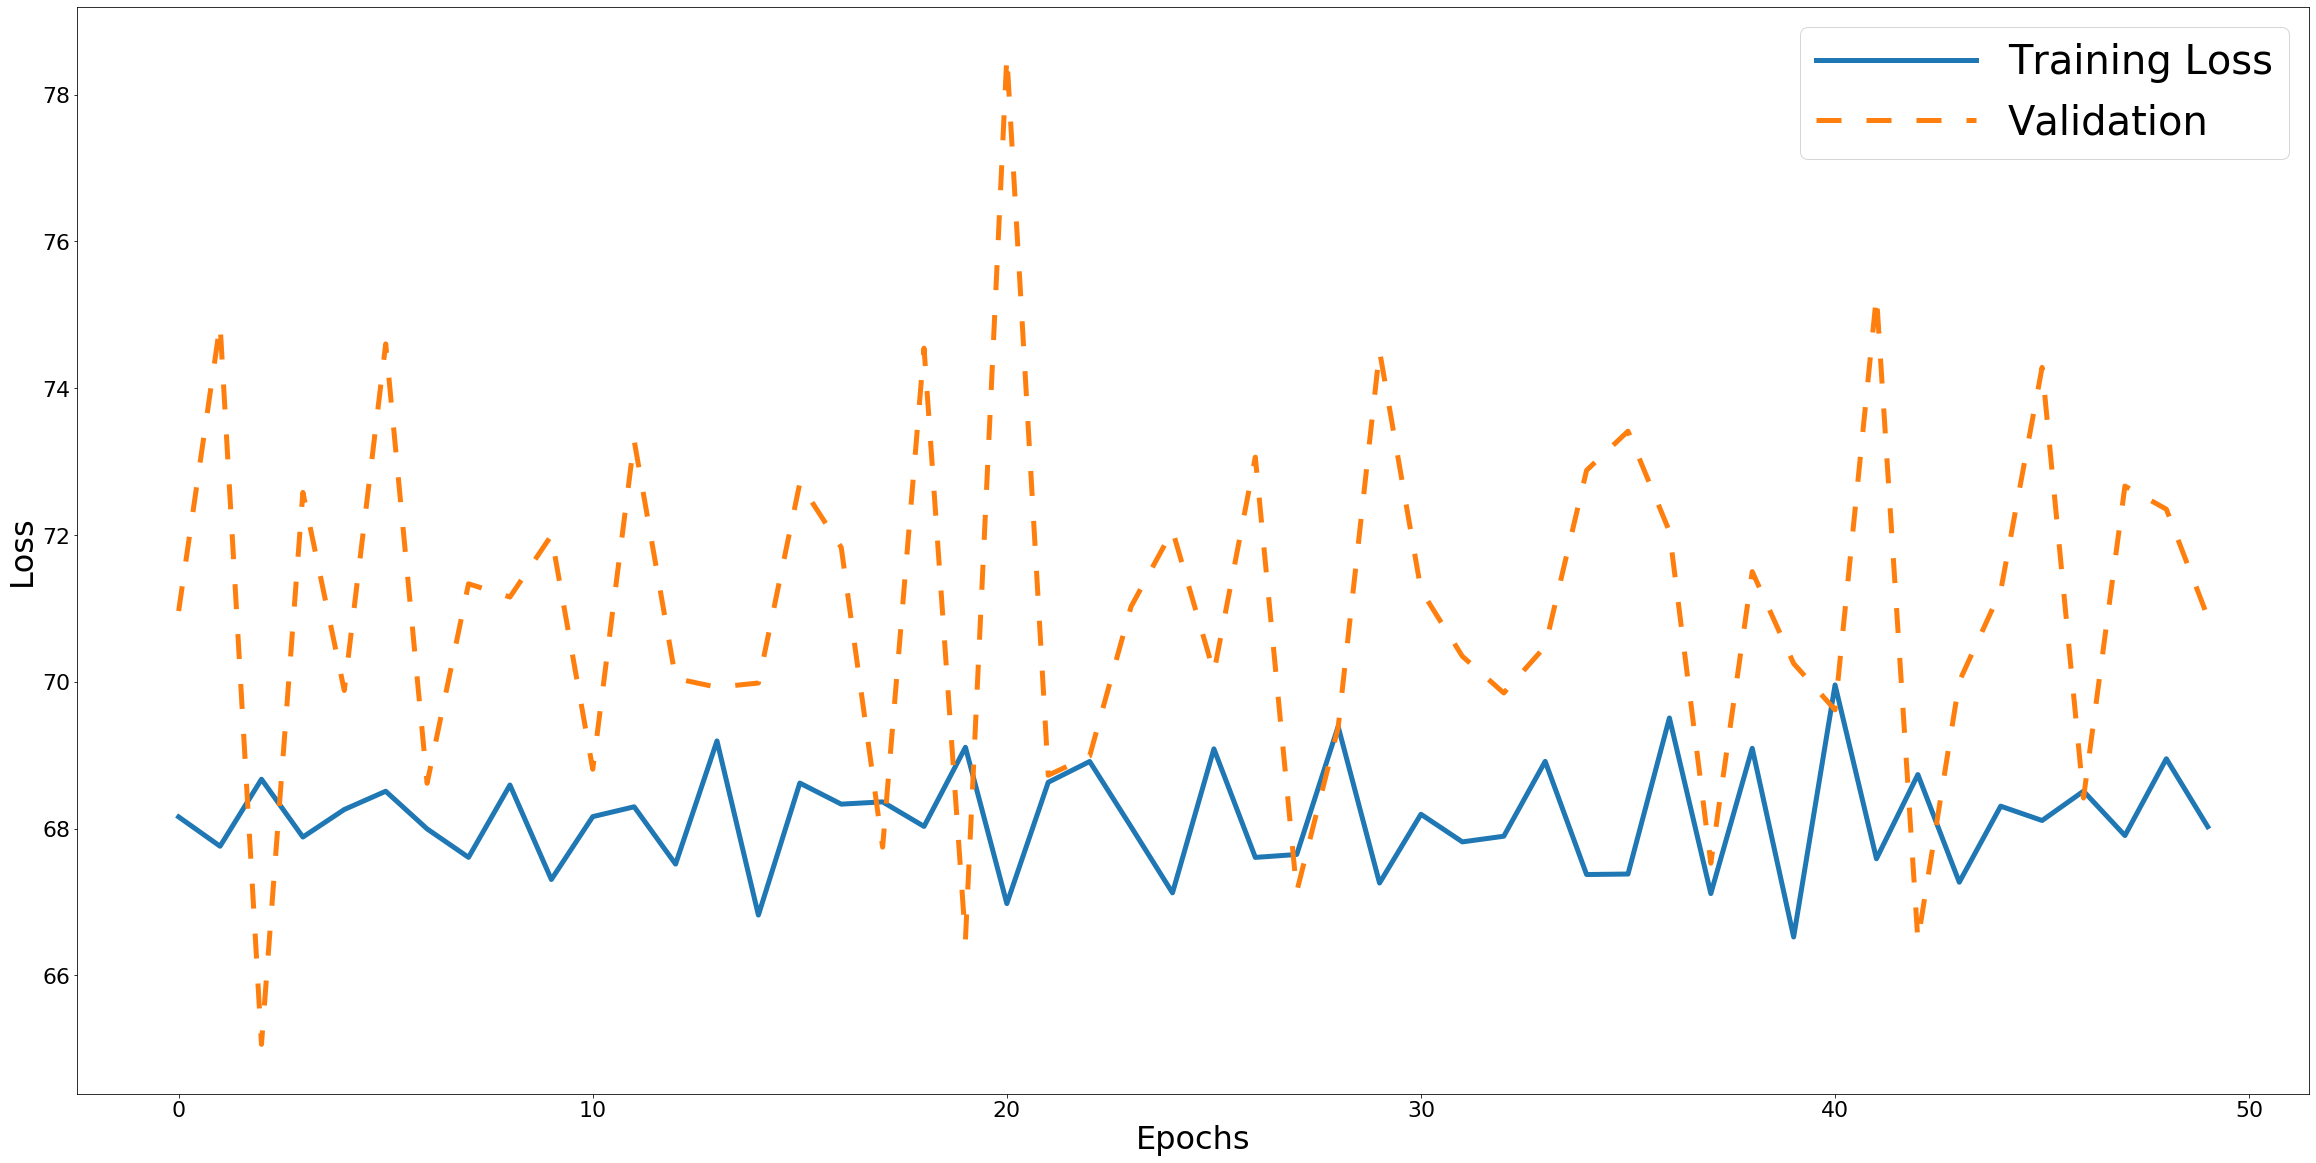

In [49]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 40,20

params = {'legend.fontsize': 40,
          'legend.handlelength': 4}
rcParams.update(params)
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels


plt.figure()
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss', linewidth = 5)
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--',dashes=(5, 5), linewidth = 5)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#plt.savefig('E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/Loss.png')
plt.show()

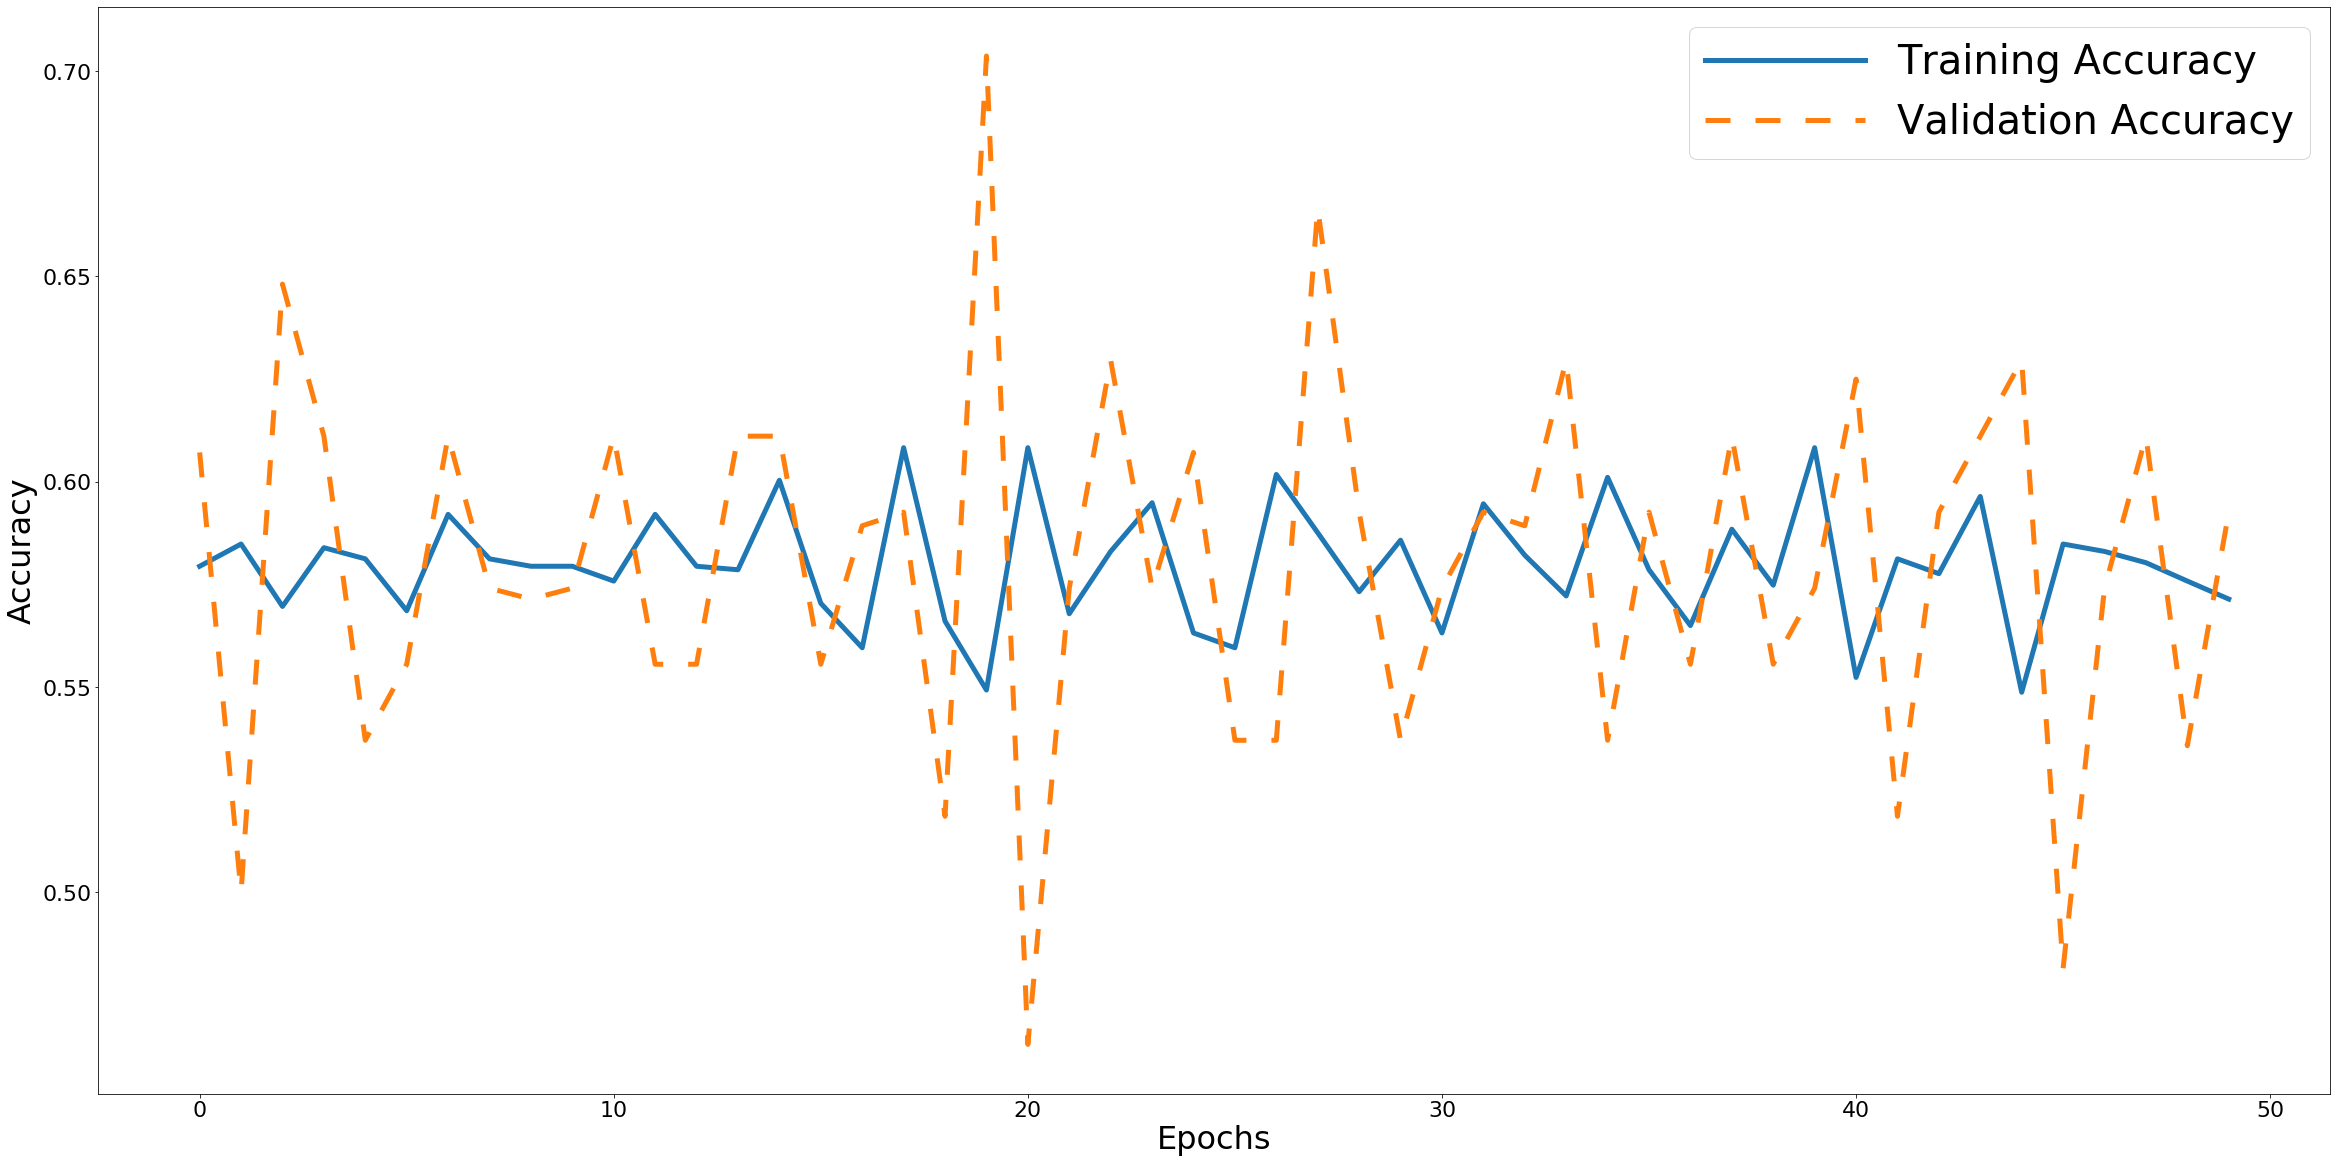

In [50]:
plt.figure()
plt.plot(hist.epoch, hist.history['acc'], label='Training Accuracy', linewidth=5)
plt.plot(
    hist.epoch, hist.history['val_acc'], label='Validation Accuracy', linestyle='--',dashes=(5, 5), linewidth=5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.savefig('E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/Acc.png')
plt.show()

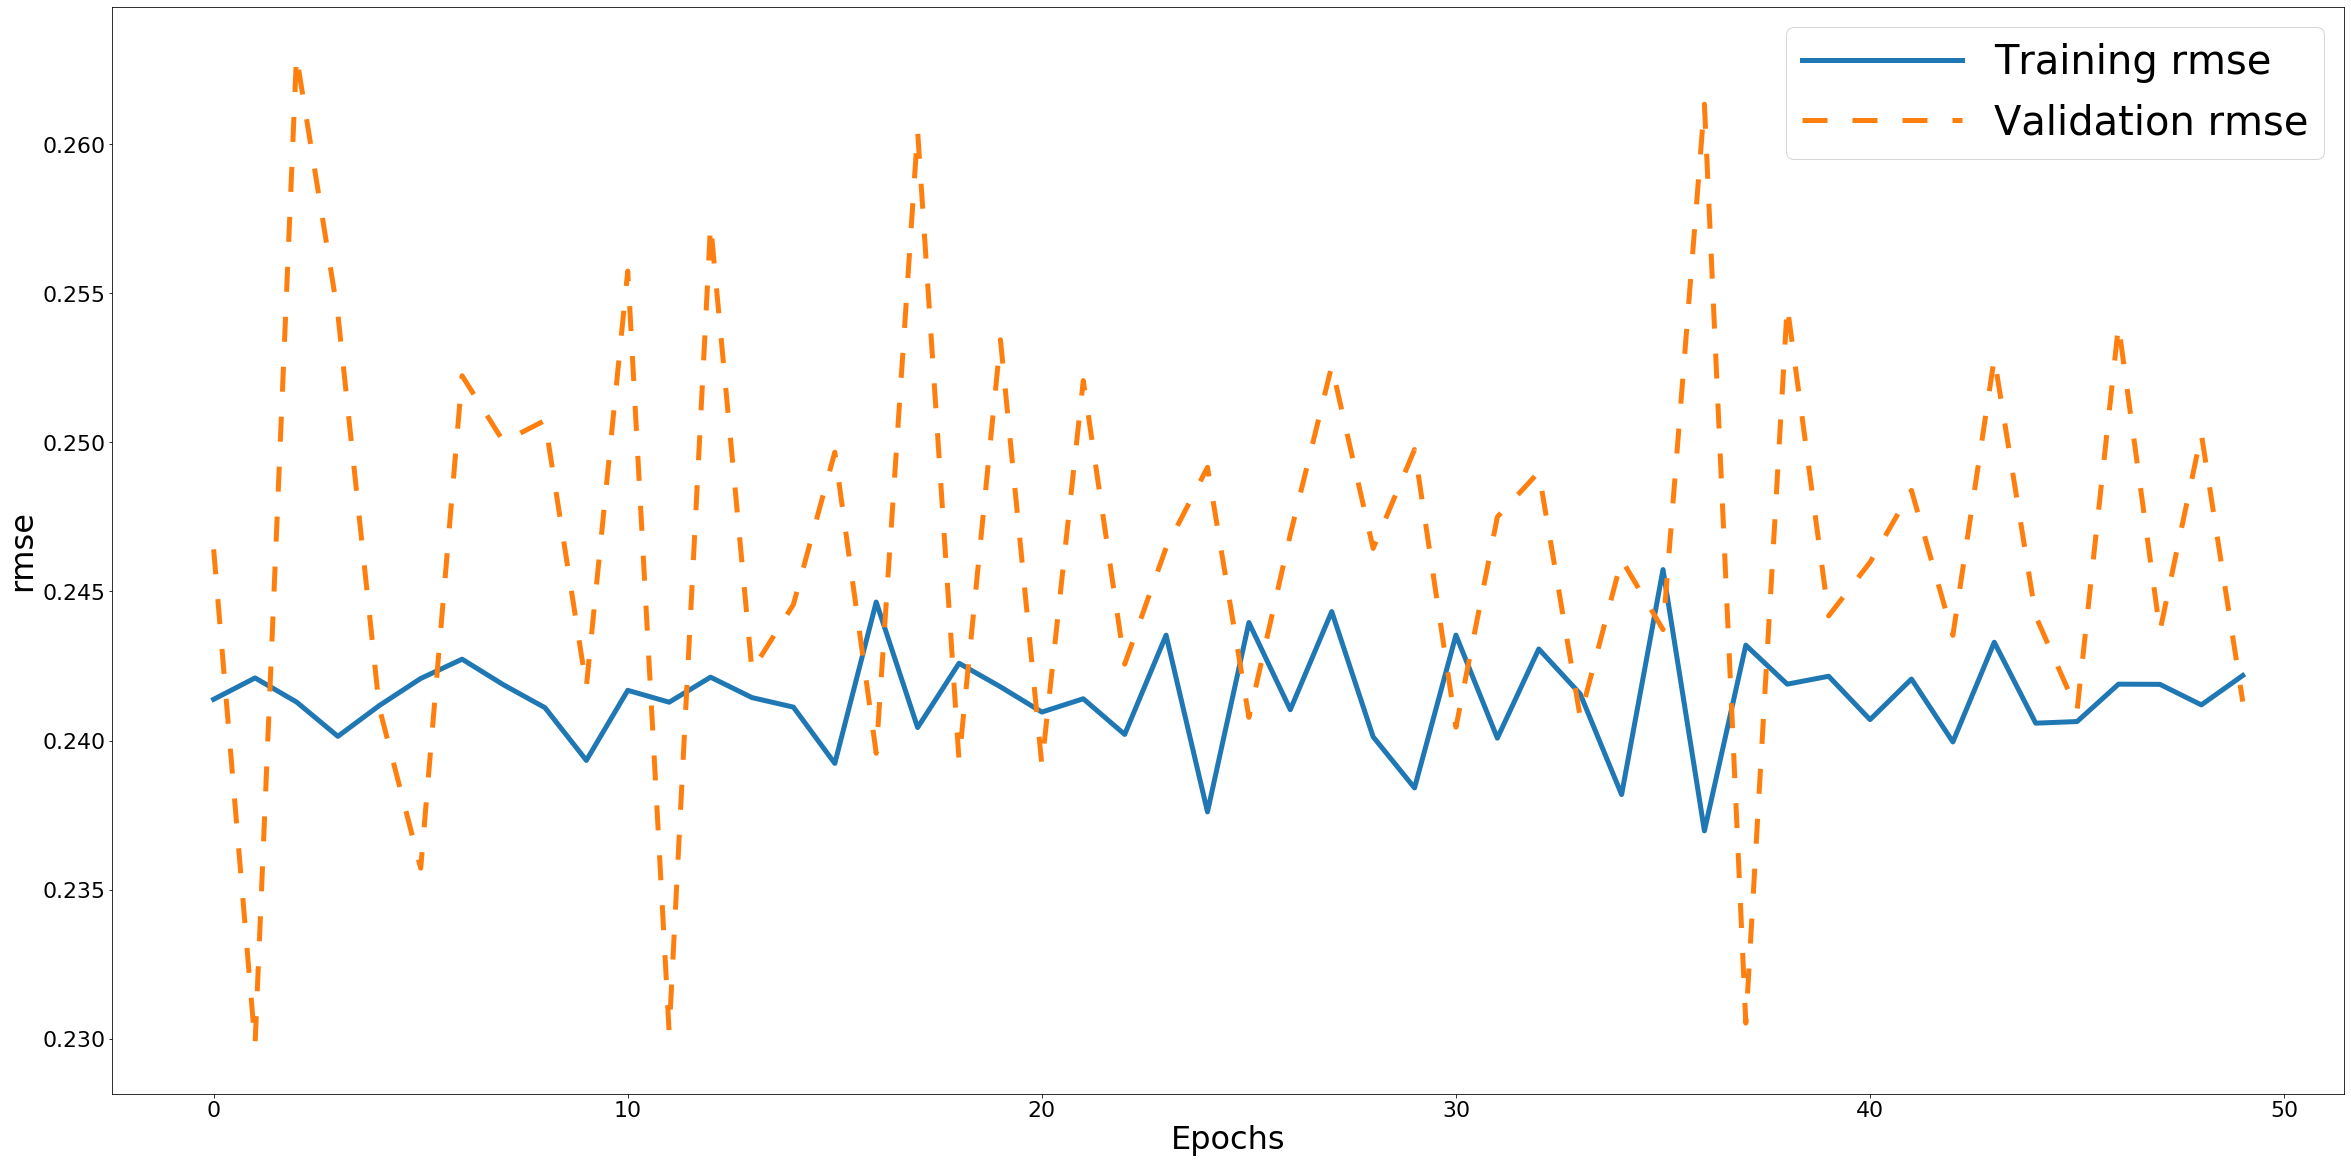

In [44]:
plt.figure()
plt.plot(hist.epoch, hist.history['rmse'], label='Training rmse', linewidth=5)
plt.plot(
    hist.epoch, hist.history['val_rmse'], label='Validation rmse', linestyle='--',dashes=(5, 5), linewidth=5)
plt.xlabel("Epochs")
plt.ylabel("rmse")
plt.legend()
#plt.savefig('E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network_2/Acc.png')
plt.show()

In [ ]:
hist_df = pd.DataFrame(hist.history) 

hist_csv_file = 'E:/Projects/Neural Net/Galaxy Zoo/Data/Results/Test_network/history_resnet152.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes = True, dpi = 300, to_file='F:/Projects/Neural Net/Galaxy Zoo/Data/Results/model.png')

In [ ]:
model = load_model('weights.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "F:/Projects/Neural Net/Galaxy Zoo/Data/images_test_rev1/",
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(224, 224),
    seed=123,
    shuffle=False)

In [ ]:
test_generator.reset()

predictions = model.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)

In [ ]:
def get_id(fname):
    return fname.replace(".jpg", "").split("\\")[1]


header = open('F:/Projects/Neural Net/Galaxy Zoo/Data/all_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")